# Universidad de Cuenca
<h2>Similaridades y diferencias entre los textos sagrados de las religiones asiáticas</h2>
<p>
    <b>Minería de textos</b><br>
    <b>Ingeniería de Sistemas</b><br>
     Edwin Narváez <br>
</p>

### Importar librerias

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from IPython.display import display
from wordcloud import WordCloud

### Lectura de datos

In [2]:
df_all_labelled  = pd.read_csv("../data/AllBooks_baseline_DTM_Labelled.csv")
df_all_unlabelled = pd.read_csv("../data/AllBooks_baseline_DTM_Unlabelled.csv")
file = open("../data/Complete_data .txt", "r")
docs = []
cont = 0
for line in file:
    stripped_line = line.strip()
    if cont%2 != 0:
        docs.append(stripped_line)
    cont = cont+1

file.close()


In [3]:
print("Total de Labelled:",df_all_labelled.shape)
print("Total de Unlabelled:",df_all_unlabelled.shape)
print("Total de text:",len(docs))

Total de Labelled: (590, 8267)
Total de Unlabelled: (590, 8266)
Total de text: 590


In [4]:
import re
df_all_labelled['Unnamed: 0'] = df_all_labelled['Unnamed: 0'].map(lambda x: re.sub('_Ch.*$', '', x), na_action='ignore')


In [5]:
df_grouped = df_all_labelled.groupby(['Unnamed: 0']).count().reset_index()
df_grouped = df_grouped[['Unnamed: 0', 'foolishness']]
df_grouped.rename(columns={"Unnamed: 0": "clase", "foolishness": "cantidad"}, inplace=True)

In [6]:
df_grouped

clase  cantidad
0  BookOfEccleasiasticus        50
1     BookOfEcclesiastes        12
2          BookOfProverb        31
3           BookOfWisdom        19
4               Buddhism        46
5             TaoTeChing        81
6              Upanishad       162
7              YogaSutra       189

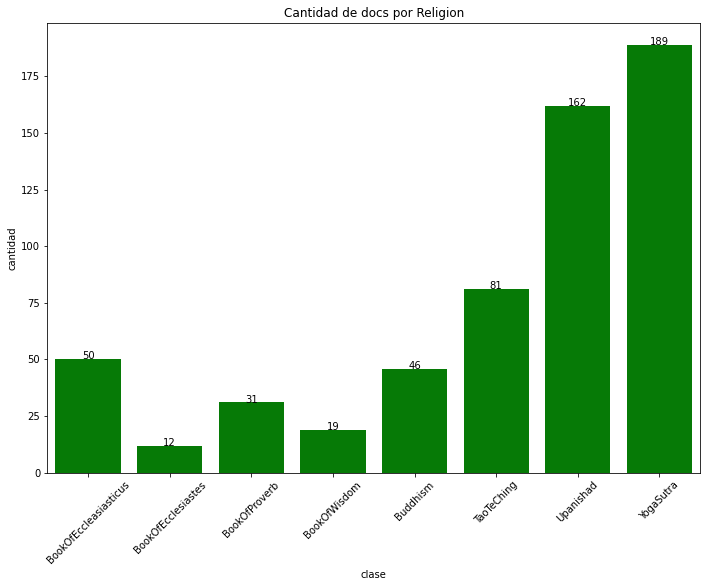

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize= (11.7, 8.27))
g = sns.barplot(x='clase', y="cantidad", data=df_grouped,
                color="green", saturation=.9)

for index, row in df_grouped.iterrows():
    g.text(row.name ,row.cantidad, round(row.cantidad,2), color='black', ha="center")

ax.set_xticklabels(ax.get_xticklabels(),rotation=45);
ax.set_title("Cantidad de docs por Religion");

plt.show()

### Preprocesamiento

#### Limpieza del texto

In [8]:
def clean_text(text):
    """Funcion que limpia una oración
    
    Parameters
    ----------
    text: str 
      original string
    
    Return
    ------
    text: str
      texto incial modificado
    """
    text = text.lower() # lowercase text
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = text.strip() # elimmina espacios al inicio o al final
    text = re.sub(r'\d+', '', text)
    STOPWORDS = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    

In [9]:
docs_limpios = list(map(clean_text, docs))

#### Stemming

In [10]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def tokenize_and_stem(text):
    text_stem = []
    stemmer= PorterStemmer()
    text_tokenizer = word_tokenize(text)
    for word in text_tokenizer:
        text_stem.append(stemmer.stem(word))
        
    return ' '.join(text_stem)

In [11]:
docs_stem = list(map(tokenize_and_stem, docs_limpios))

### Representación Vectorial TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer( ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(docs_stem)

In [13]:
tfidf_matrix.shape

(590, 51991)

## Modelos

### KMeans

> Silueta Score: indica que tan buena es la asignación de una observación de su cluster comparando su similitud con el resto de documentos pertenecientes a ese cluster

For n_clusters = 2 The average silhouette_score is : 0.00872332901630814
For n_clusters = 3 The average silhouette_score is : 0.010045216634697545
For n_clusters = 4 The average silhouette_score is : 0.0034668303751380805
For n_clusters = 5 The average silhouette_score is : 0.002669432802342642
For n_clusters = 6 The average silhouette_score is : 0.004206885600270442
For n_clusters = 7 The average silhouette_score is : 0.004665731163574041
For n_clusters = 8 The average silhouette_score is : 0.0038971579636563106
For n_clusters = 9 The average silhouette_score is : 0.0036300600047571054


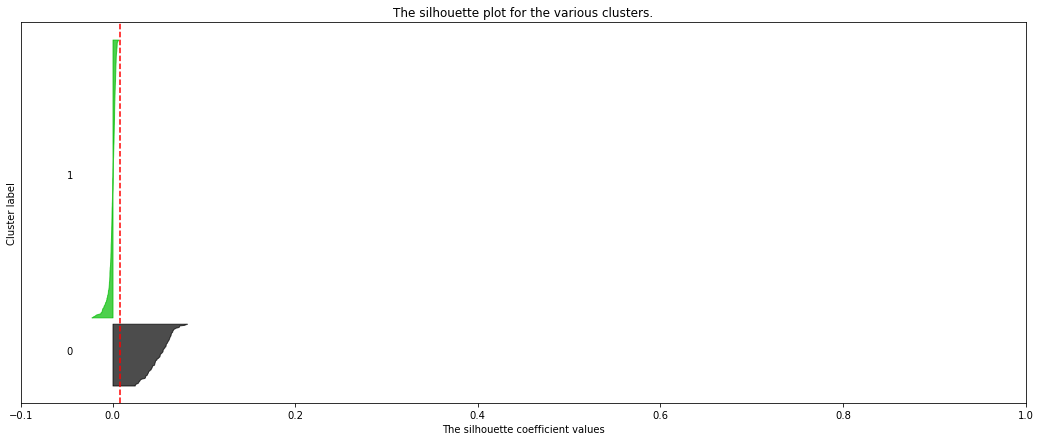

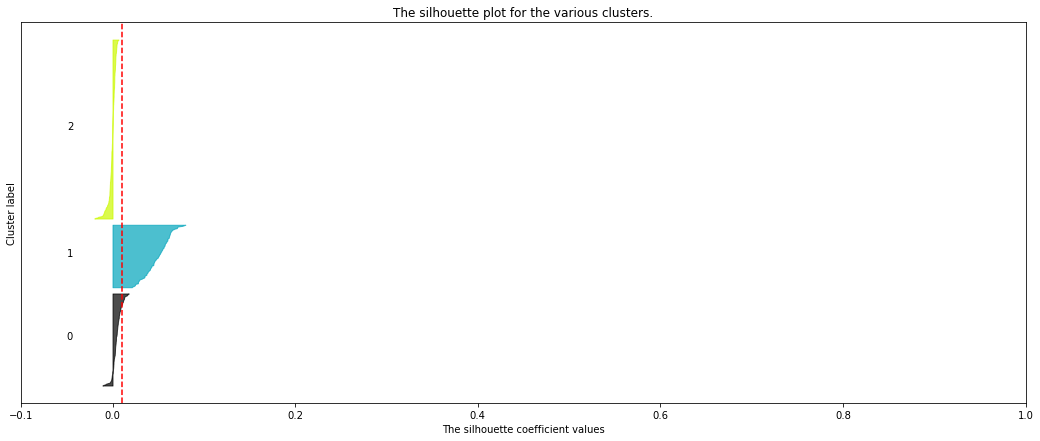

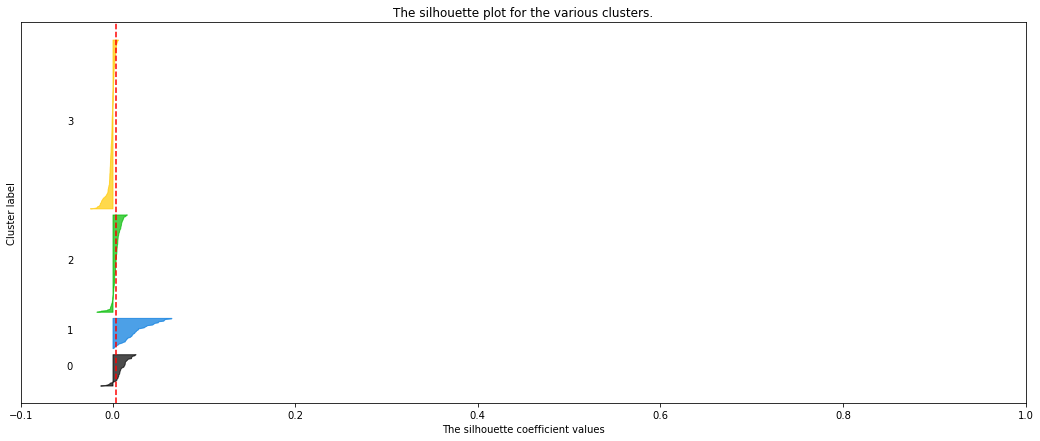

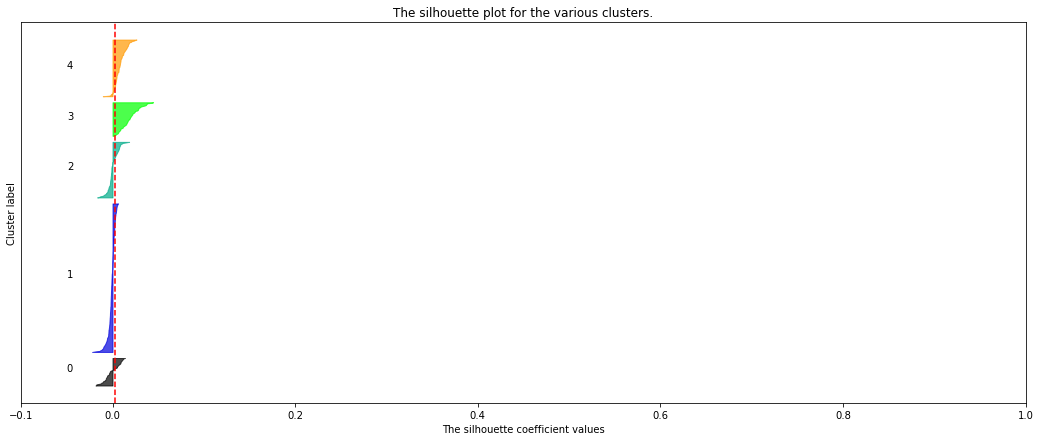

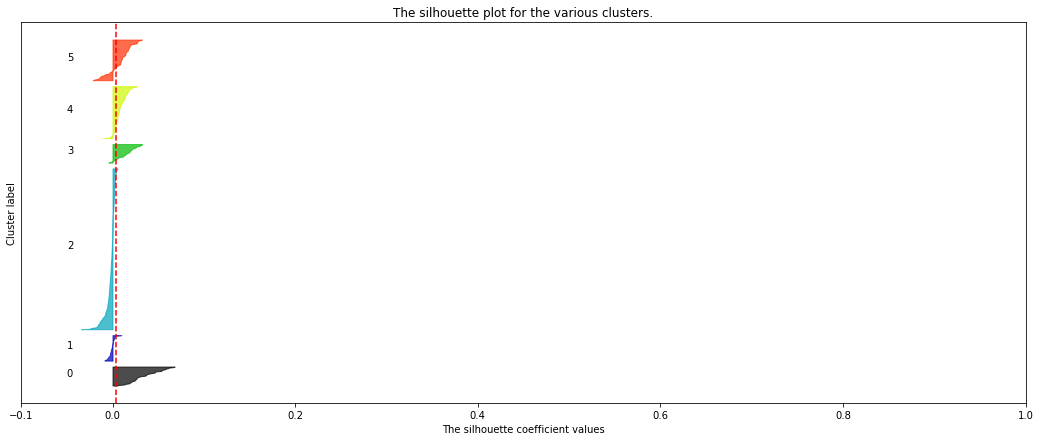

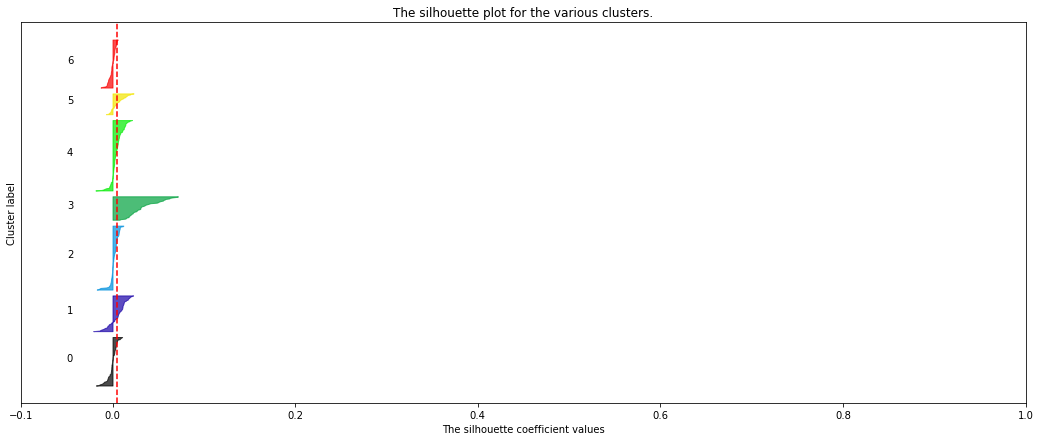

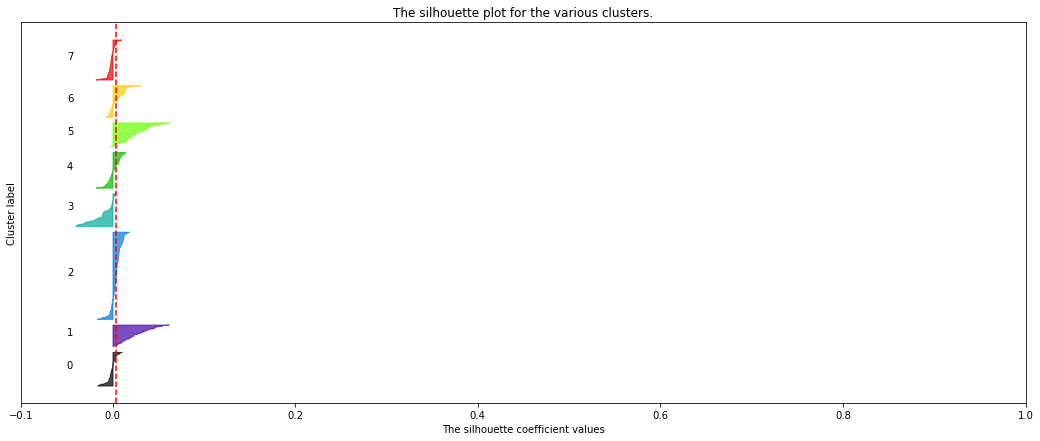

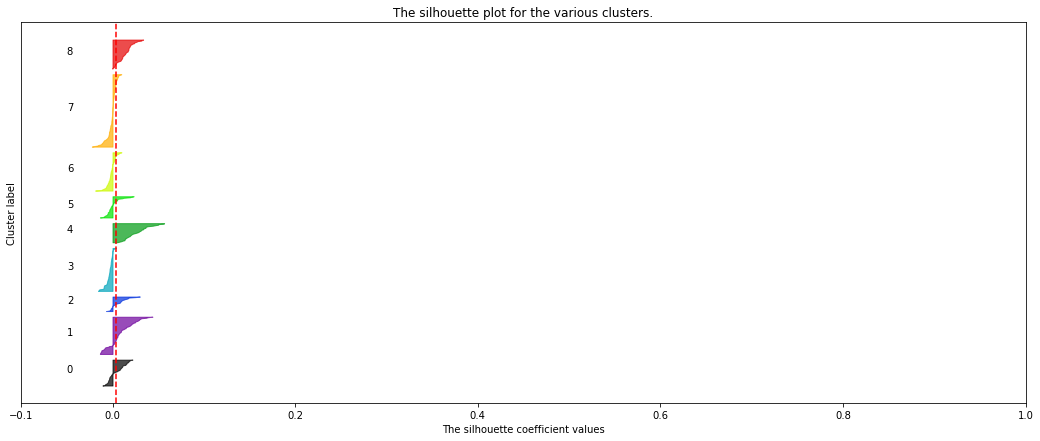

In [14]:
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm

range_n_clusters = range(2,10)
silhouette_euclideans = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++')
    cluster_labels = clusterer.fit_predict(tfidf_matrix)
    silhouette_euclideans.append(silhouette_score(tfidf_matrix, cluster_labels, metric="euclidean"))
    
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])

    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(tfidf_matrix, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

silhoutte_scores=pd.DataFrame(list(zip(range_n_clusters,silhouette_euclideans)),columns=['K','Silhouette (Euclidean)'])
silhoutte_scores = silhoutte_scores.sort_values(by=['Silhouette (Euclidean)'],ascending=False)

In [15]:
k_true = int(silhoutte_scores[0:1]['K'])

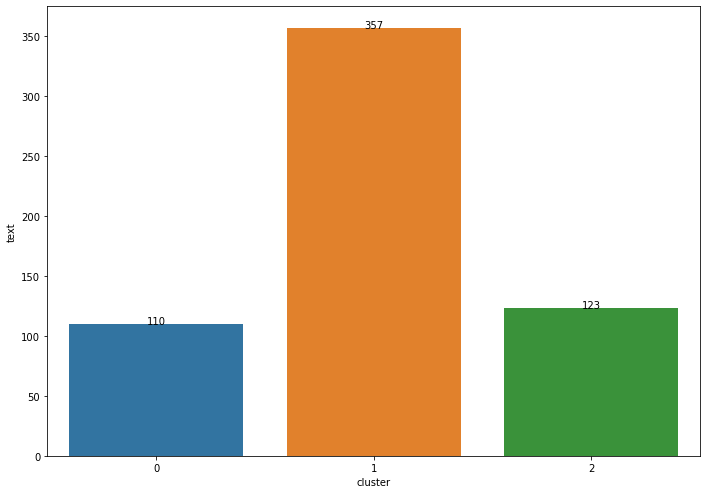

In [16]:
model = KMeans(n_clusters=k_true, init='k-means++', max_iter=200, n_init=10,random_state=100)
model.fit(tfidf_matrix)
labels=model.labels_
cluster_result=pd.DataFrame(list(zip(docs_stem,labels)),columns=['text','cluster'])
cluster_grouped=cluster_result.groupby('cluster').count()
cluster_grouped.reset_index(level=0, inplace=True)

fig, ax = plt.subplots(figsize= (11.7, 8.27))
g=sns.barplot(x='cluster', y='text',data=cluster_grouped )
for index, row in cluster_grouped.iterrows():
    g.text(row.name,row.text, round(row.text,2), color='black', ha="center")

plt.show()

In [17]:
from sklearn.manifold import MDS

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

mds = MDS(n_components=2, random_state=1)

pos = mds.fit_transform(dist) 
xs, ys = pos[:, 0], pos[:, 1]

titles= df_all_labelled['Unnamed: 0'].tolist()

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


In [18]:
indexes = np.unique(titles, return_index=True)[1]
labels_for_scatter = [titles[index] for index in sorted(indexes)]

df_all_labelled['Unnamed: 0'].replace(to_replace=df_all_labelled['Unnamed: 0'].unique(), value=[1, 2, 3, 4, 5, 6, 7 ,8], inplace=True)

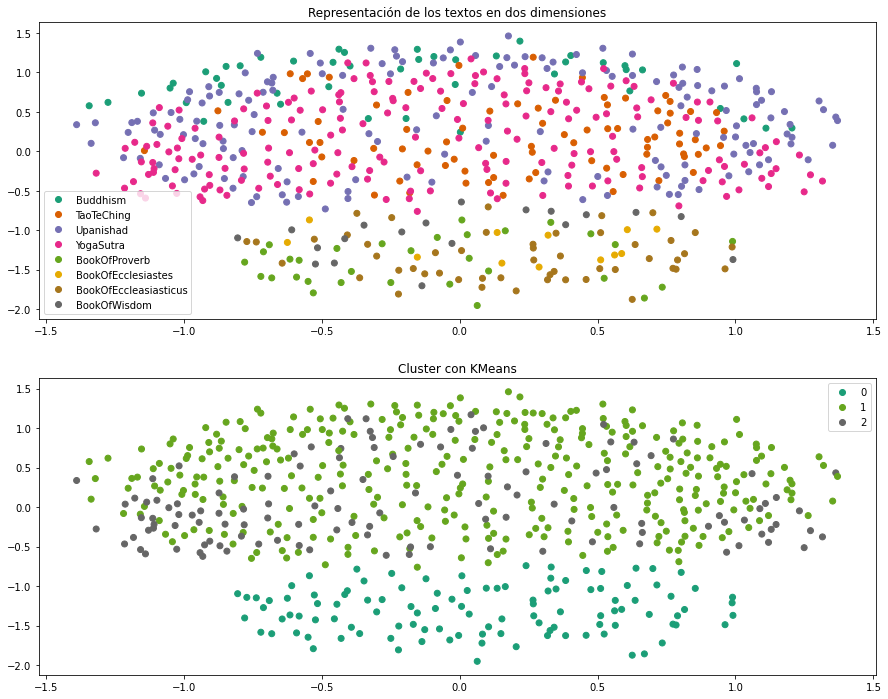

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
scatter1 = ax1.scatter(xs, ys, c= np.array(df_all_labelled['Unnamed: 0'].to_list()), cmap='Dark2' )
ax1.legend(handles= scatter1.legend_elements()[0], labels=labels_for_scatter)
ax1.set_title("Representación de los textos en dos dimensiones")

scatter2 = ax2.scatter(xs, ys, c=labels, cmap='Dark2')
ax2.set_title("Cluster con KMeans")
ax2.legend(handles= scatter2.legend_elements()[0], labels=range(0,k_true))

plt.show()

Cluster: 0


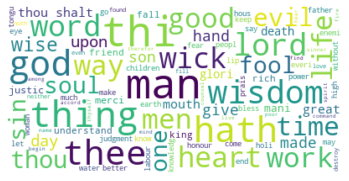

Cluster: 1


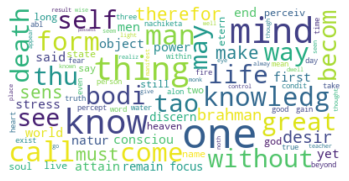

Cluster: 2


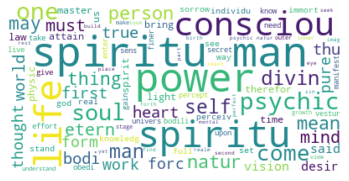

In [20]:

result={'cluster':labels,'text':docs_stem}
result=pd.DataFrame(result)

for k in range(0,k_true):
    s=result[result.cluster==k]
    text=s['text'].str.cat(sep=' ')

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    
    print('Cluster: {}'.format(k))

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#### Cluster Jerárquico

In [21]:
from scipy.cluster.hierarchy import linkage, ward, dendrogram
linkage_matrix = linkage(dist, 'average')

#### Cophenet Score

In [22]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
c, coph_dists = cophenet(linkage_matrix, pdist(dist))
c

0.8225660903337864

> Cophenet es una medida de cuán fielmente un dendograma conserva las distancias por pares entre los puntos de datos

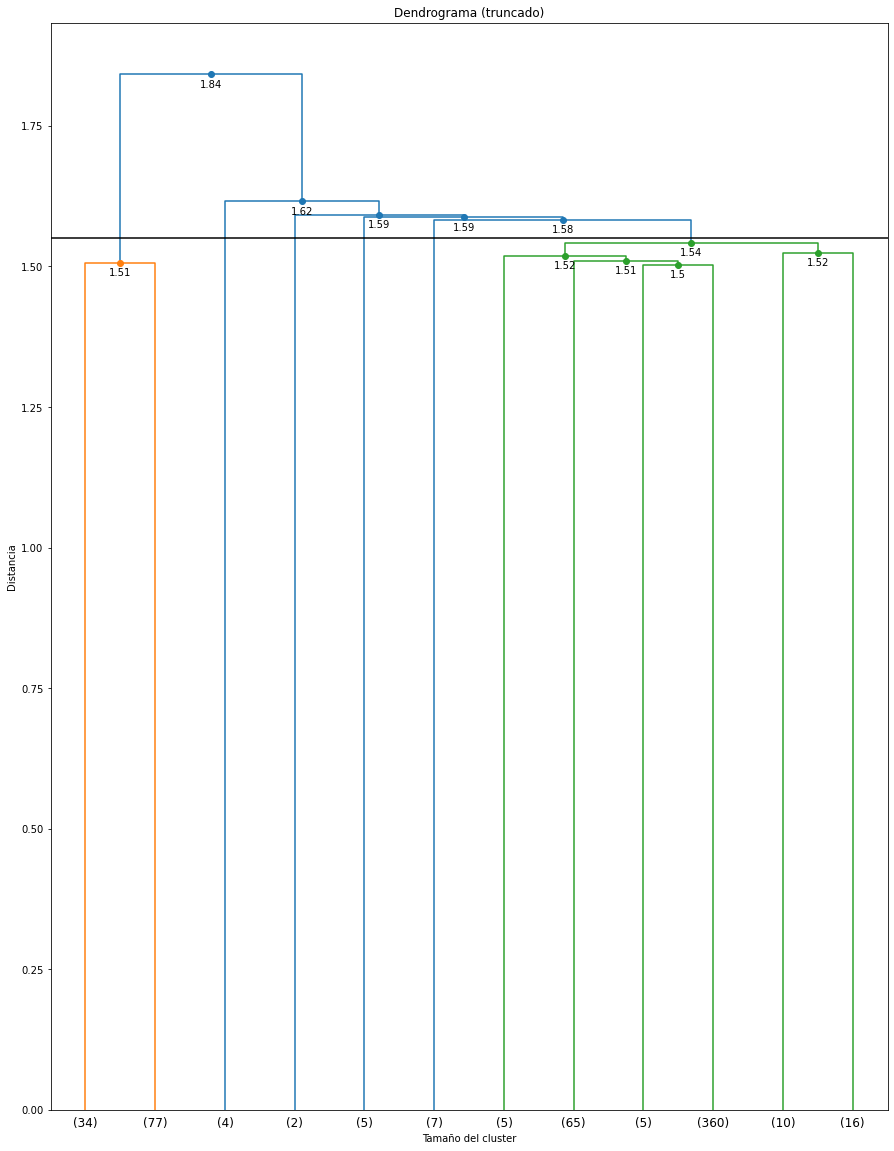

In [23]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Dendrograma (truncado)')
        plt.xlabel('Tamaño del cluster')
        plt.ylabel('Distancia')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

max_d = 1.55
fig, ax = plt.subplots(figsize=(15, 20)) # set size

fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=12,
    max_d=max_d,
)
plt.show()


In [24]:
from scipy.cluster.hierarchy import fcluster

clusters_jerarquico_distance = fcluster(linkage_matrix, max_d, criterion='distance')


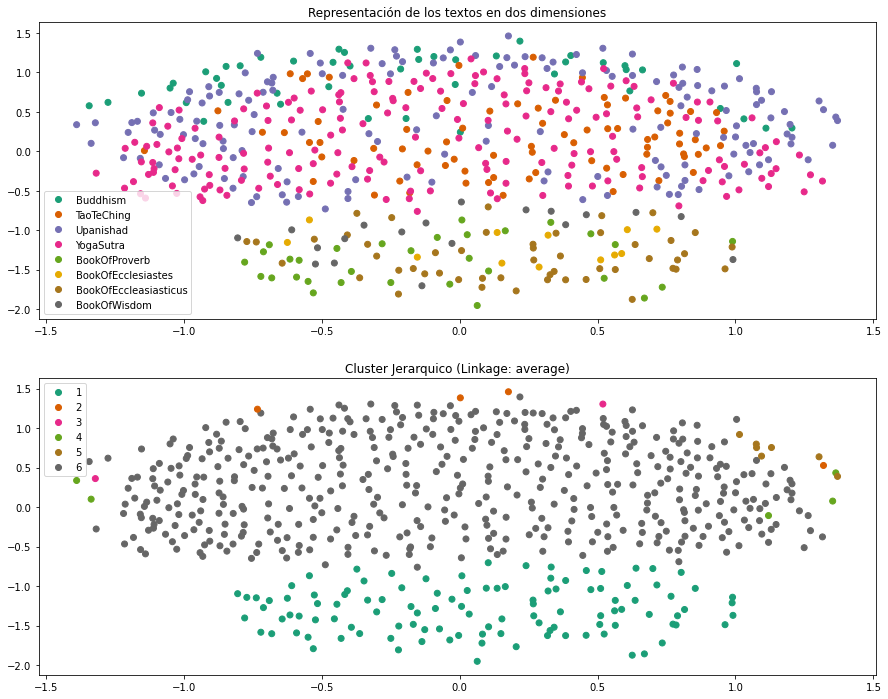

In [25]:
k_jerarquico= 6
clusters_jerarquico_k = fcluster(linkage_matrix, k_jerarquico, criterion='maxclust')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
scatter1 = ax1.scatter(xs, ys, c= np.array(df_all_labelled['Unnamed: 0'].to_list()), cmap='Dark2')
ax1.legend(handles= scatter1.legend_elements()[0], labels=labels_for_scatter)
ax1.set_title("Representación de los textos en dos dimensiones")

scatter2 = ax2.scatter(xs, ys, c=clusters_jerarquico_k, cmap='Dark2')
ax2.set_title("Cluster Jerarquico (Linkage: average)")
ax2.legend(handles= scatter2.legend_elements()[0], labels=range(1,k_jerarquico+1))

plt.show()

Cluster: 1


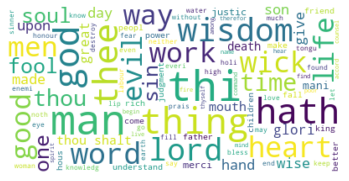

Cluster: 2


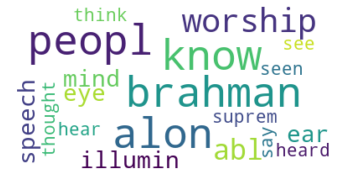

Cluster: 3


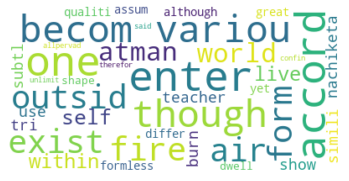

Cluster: 4


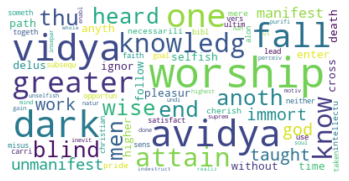

Cluster: 5


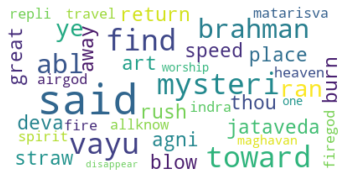

Cluster: 6


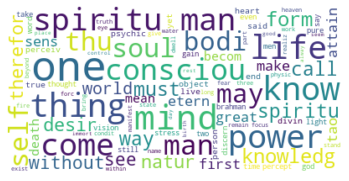

In [26]:

result={'cluster':clusters_jerarquico_k,'text':docs_stem}
result=pd.DataFrame(result)

for k in range(1,k_jerarquico+1):
    s=result[result.cluster==k]
    text=s['text'].str.cat(sep=' ')

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    
    print('Cluster: {}'.format(k))

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

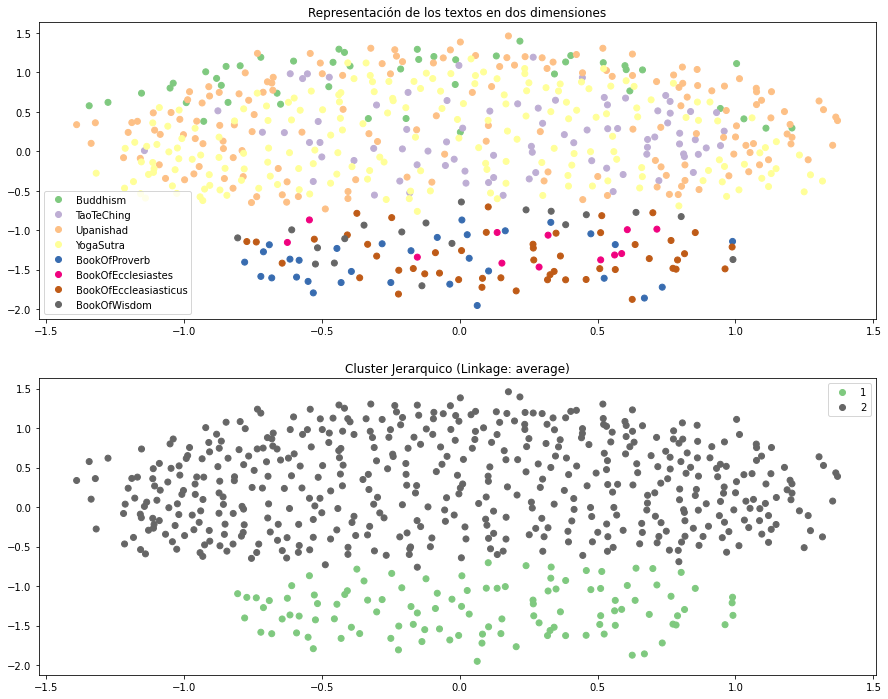

In [27]:
k_jerarquico= 2
clusters_jerarquico_k = fcluster(linkage_matrix, k_jerarquico, criterion='maxclust')
#clusters_jerarquico_k
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
scatter1 = ax1.scatter(xs, ys, c= np.array(df_all_labelled['Unnamed: 0'].to_list()), cmap='Accent')
ax1.legend(handles= scatter1.legend_elements()[0], labels=labels_for_scatter)
ax1.set_title("Representación de los textos en dos dimensiones")

scatter2 = ax2.scatter(xs, ys, c=clusters_jerarquico_k, cmap='Accent')
ax2.set_title("Cluster Jerarquico (Linkage: average)")
ax2.legend(handles= scatter2.legend_elements()[0], labels=range(1,k_jerarquico+1))

plt.show()

Cluster: 1


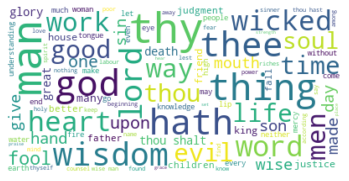

Cluster: 2


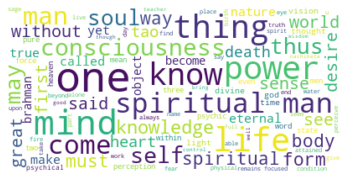

In [28]:

result={'cluster':clusters_jerarquico_k,'text':docs_limpios}
result=pd.DataFrame(result)

for k in range(1,k_jerarquico+1):
    s=result[result.cluster==k]
    text=s['text'].str.cat(sep=' ')

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    
    print('Cluster: {}'.format(k))

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

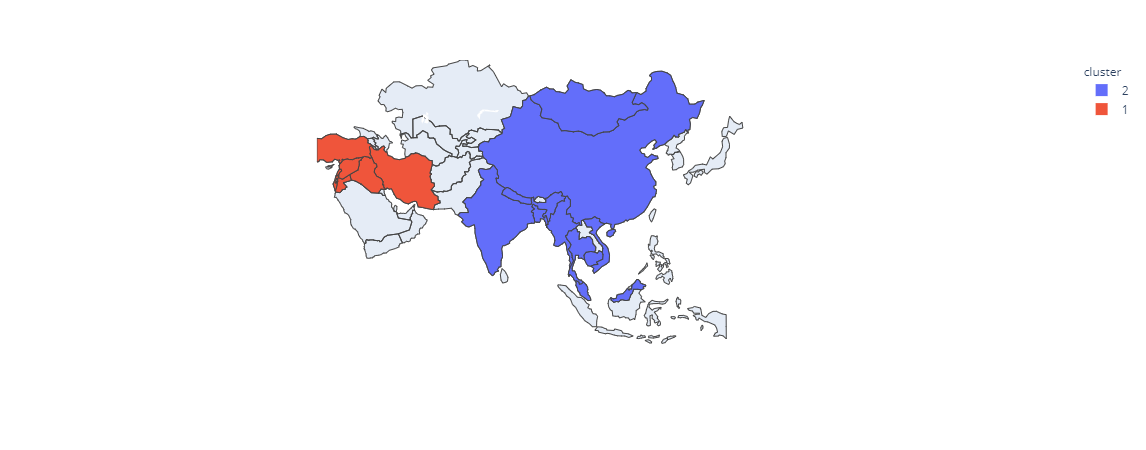

In [29]:
import plotly.express as px
df_new = px.data.gapminder().query("year==2007")

dic_map = {
    'China': 2,'India': 2,'Nepal':2, 'Butan':2, 'Bangladesh':2, 'Mongolia':2, 'Thailand':2, 'Vietnam':2,'Myanmar':2, 'Malaysia':2, 'Cambodia':2, 
    'Israel':1, 'Jordan':1, 'Lebanon':1, 'Turkey':1,'Syria':1, 'Iran':1, 'Iraq':1
}

df_map = df_new.loc[df_new["country"].isin(['China', 'India', 'Nepal', 'Butan', 'Bangladesh', 'Mongolia', 'Thailand', 'Vietnam',
                                                'Myanmar', 'Malaysia', 'Cambodia', 'Israel', 'Jordan', 'Lebanon', 'Turkey',
                                                 'Syria', 'Iran', 'Iraq'])]

df_map = df_map[['country','continent','iso_alpha']]
df_map['cluster'] = 0
df_map['cluster'] = df_map['country'].apply( lambda x : str(dic_map[x]) )
df_map.reset_index(inplace = True, drop=True)


fig = px.choropleth(df_map, locations="iso_alpha",
                    color = "cluster",
                    scope = "asia",
                    hover_name = "country")

#fig.write_html('map1.html', auto_open=True)
fig.show()

### Conclusiones

<p>Se puede concluir que los textos que pertenecen a las religiones del este de Asia: taoísmo, budismo e hinduismo tienen muchas similitudes entre sí, porque a pesar de no ser las mismas religiones los tér-minos que componen sus textos sagrados se relacionan en mayormente entre los miembros del mismo clúster en mayor medida que los textos de la religión cristiana. Esto también se pudo evidenciar cuando se clusterizaba a través de clúster jerárquicos, a medida que K aumentaba se dividía el clúster de religiones del este de Asia, pero se encontraban grupos muy desbalanceados, es decir, el Tao Te Ching y el Upanishads no se separaban y algunos pocos documentos de los textos religiosos formaban pequeños grupos. Por lado de los textos cristia-nos siempre permanecían juntos ya que pertenecen a la misma religión.</p>

<p>También se pudo diferenciar claramente las postu-ras de las religiones predominantes en Asia. La religión cristiana que se basa en la presencia de un Dios más poderoso que el humano, quien está en una escala superior, que controla todo y puede castigar o premiar en una vida posterior a la muerte y por otro lado las religiones del este de Asia que cultivan las virtudes de cada persona con el fin de hacer que la estadía en la vida terrenal sea más placentera. </p>

<p>Un potencial trabajo futuro se podría extraer de este análisis direccionándolo a la extracción de características de los textos con LDA. También se podría direccionar el análisis con otros modelos como DBSCAN para hallar posibles nuevos clúster en los documentos con alta densidad.</p>
